Wykorzystane moduły

In [62]:
from math import sin, cos, pi, factorial
import matplotlib.pyplot as plt
import numpy as np
import copy
from bisect import bisect_left, bisect_right
from enum import Enum
from itertools import chain

Zadana funkcja

In [2]:
def f(x):
    return 30 + (x**2 / 1.5) - 30 * cos(1.5 * x)

Zadany przedział

In [3]:
f_range_a = -4 * pi
f_range_b = 4 * pi

Pochodna zadanej funkcji

In [4]:
def g(x):
    return 45 * sin(1.5 * x) + ( (4 * x) / 3)

Funkcja rysująca wykres funkcji

In [5]:
def plot_function(func, range_a, range_b, title, color):
    
    func_x = np.linspace(range_a, range_b, 10000)
        
    func_y = list(map(func, func_x))

    plt.plot(func_x, func_y, label = title, color = color)

    plt.legend()
    plt.grid(True)
    plt.savefig("zadana_funkcja.png")

Wykres zadanej funkcji

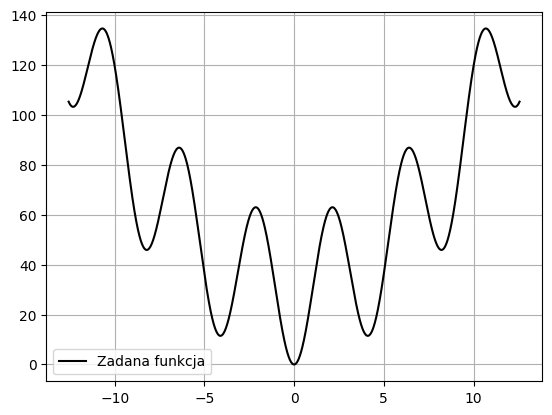

In [6]:
plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "black")

Wykres pochodnej zadanej funkcji

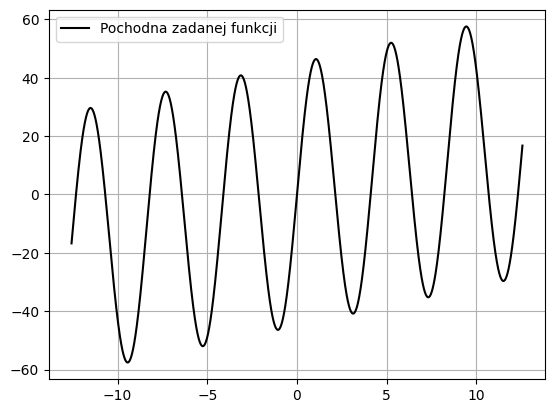

In [7]:
plot_function(g, f_range_a, f_range_b, "Pochodna zadanej funkcji", "black")

Sposoby generacji węzłów

Węzły równoodległe

In [8]:
def get_evenly_distributed(a, b, n = 100):
    
    length = abs(b - a)
    h = length / (n - 1)
    
    return [a + i * h for i in range(n - 1)] + [b]

Węzły Czebyszewa

In [9]:
def get_chebyshev_nodes(a, b, n):

    nodes = []

    for k in range(1, n + 1):

        nodes.append( 0.5 * (a + b) + 0.5 * (b - a) *  cos( ( (2 * k - 1) / (2 * n) ) * pi ) )
    
    return nodes[::-1]

Interpolacja lagrange'a

In [10]:
def lagrange_interpolation(xs, ys, x): 

    if len(xs) != len(ys): return

    P = 0 #Value of a polynomial at point x

    for i in range(len(xs)):

        L = 1 #lagrange's base

        for j in range(len(xs)):

            if xs[i] != xs[j]: 

                L *= (x - xs[j]) / (xs[i] - xs[j])

        P += (L * ys[i])

    return P

Interpolacja newtona

In [11]:
def newton_interpolation(xs, ys, x):

    if len(xs) != len(ys): return

    coefficients = [ys[0]]

    #Dfference quotients array
    diffs = copy.deepcopy(ys)
    
    for i in range(len(xs) -2, -1, -1):

        for j in range(0, i + 1):
            
            diffs[j] = (diffs[j+1] - diffs[j]) / (xs[j + ((len(xs) - i) - 1)] - xs[j])

        coefficients.append(diffs[0])

    #horner
    result = coefficients[-1]

    for i in range(len(coefficients) - 2, -1, -1):
        result = result * (x - xs[i]) + coefficients[i]

    return result

Interpolacja Hermite'a

In [12]:
def hermite_interpolation(xs, ys, x):

    #Tworzy wektor z wartośami [x1, x1, x1, x2, x2, ...], gdzie ilośc xi to ilość wartości funkcji i pochodnych dla danego x-a
    x_map = []
    for i, mi in enumerate(ys):
        for _ in range(len(mi)):
            x_map.append(xs[i])

    #Wyznaczam sumę krotności
    m = sum([len(mi) for mi in ys])
    
    #Tworzę początkową macierz
    A = [[ None for j in range(m)] for i in range(m)]
    
    #Wypełniam macierz znanym wartościami f(x)
    current_row = 0
    for mi in ys:
        for j in range(len(mi)):
            A[current_row][0] = mi[0]
            current_row += 1
            
    #Wypełniam macierz znanymi wartościami pochodnych
    row = 0
    for mi in ys:
        for i in range(len(mi)):
            for j in range(1, i + 1):
                A[row][j] = mi[j] / factorial(j)
            row += 1
            
    #Wypełniam macierz wylioczonymi różnicami i wyliczam wspolczynniki
    coefficients = [A[0][0]]
    for i in range(1, m): #Aktualna pozycja do ktorej zmierzamy
        for j in range(1, i + 1):
            if A[i][j] == None:
                A[i][j] = (A[i][j - 1] - A[i - 1][j - 1]) / (x_map[i] - x_map[i - j])
        coefficients.append(A[i][i])
        
    #pretty_print(A)
    
    diffs = [x - xi for xi in x_map]
    
    w = coefficients[0]
    
    for i in range(1, m):
        
        temp = coefficients[i]
        
        for j in range(0, i):
            temp *= diffs[j]
            
        w += temp
        
    return w  

Rysowanie interpolacji

In [13]:
def draw_interpolation(interpolation_function, point_generation_function, n, filename, test_points_count = 1000, nodes_plot_label = 'Węzły'):
    
    xs = point_generation_function(f_range_a, f_range_b, n)

    if interpolation_function == hermite_interpolation:
        ys = [(f(xs[i]), g(xs[i])) for i in range(len(xs))]
    else:
        ys = [f(xs[i]) for i in range(len(xs))]

    check_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
    check_y = []

    for i in range(len(check_x)):

        check_y.append(interpolation_function(xs, ys, check_x[i]))

    plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "blue")
    plt.plot(check_x, check_y, color = 'red', label = "Funkcja interpolująca")
    if interpolation_function ==hermite_interpolation:
        plt.scatter(xs, np.array(ys)[:, 0], color = 'black', label=nodes_plot_label)
    else:
        plt.scatter(xs, ys, color = 'black', label=nodes_plot_label)
    
    plt.legend()
    plt.grid(True)
    plt.savefig(filename + ".png")
    plt.show()


Błąd maskymmalny dla interpolacji

In [14]:
def interpolation_maximum_difference(interpolation_function, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    global_max = float('-inf')
    global_min = float('inf')
    
    global_max_n = -1
    global_max_n = -1

    for i in range(len(N)):

        maksimum = float('-inf')

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])
        if interpolation_function == hermite_interpolation:
            ys = [ (f(xs[i]), g(xs[i])) for i in range(len(xs))]
        else:
            ys = [f(xs[i]) for i in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            temp = abs(f(test_x[j]) - interpolation_function(xs, ys, test_x[j]))

            maksimum = temp if temp > maksimum else maksimum
    
        if maksimum > global_max: 
            global_max = maksimum
            global_max_n = N[i]
        if maksimum < global_min: 
            global_min = maksimum
            global_min_n = N[i]
        
    return global_min, global_min_n, global_max, global_max_n

Błąd śreniokwadratowy dla interpolacji

In [15]:
def interpolation_mean_difference(interpolation_function, point_generation_function, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    global_max = float('-inf')
    global_min = float('inf')
    
    global_max_n = -1
    global_max_n = -1

    for i in range(len(N)):

        suma = 0

        #Evenly distributed xs
        xs = point_generation_function(f_range_a, f_range_b, N[i])

        if interpolation_function == hermite_interpolation:
            ys = [ (f(xs[i]), g(xs[i])) for i in range(len(xs))]
        else:
            ys = [f(xs[i]) for i in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            suma += (f(test_x[j]) - interpolation_function(xs, ys, test_x[j])) ** 2

        suma /= test_points_count
        
        if suma > global_max:
            global_max = suma
            global_max_n = N[i]
            
        if suma < global_min:
            global_min = suma
            global_min_n = N[i]

    return global_min, global_min_n, global_max, global_max_n

Analiza wszystkich interpolacji

Przykładowy wykres dla interpolacji lagrange'a i równoodległych węzłów

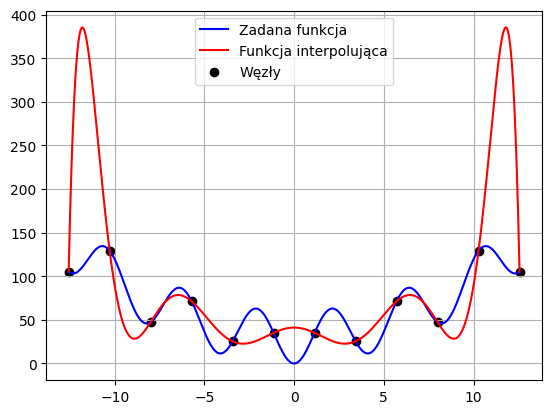

In [16]:
draw_interpolation(lagrange_interpolation, get_evenly_distributed, 12, "img01")

Przykładowy wykres dla interpolacji lagrange'a i węzłów Czebyszewa

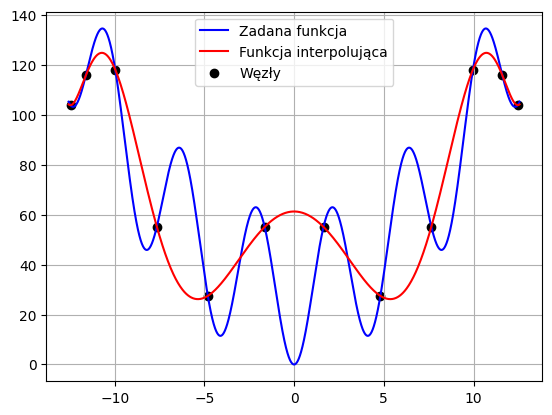

In [27]:
draw_interpolation(lagrange_interpolation, get_chebyshev_nodes, 12, "img02")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji lagrangea i liczby równoodległych węzłów z przedziału [3, 100]

In [39]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(lagrange_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.00016155836900111353 43 8887819690609.293 100


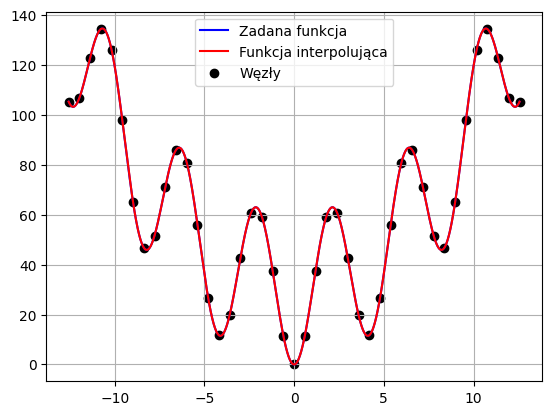

In [46]:
draw_interpolation(lagrange_interpolation, get_evenly_distributed, 43, "img03")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji lagrangea i liczby równoodległych węzłów z przedziału [3, 100]

In [17]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(lagrange_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

2.0525728498452304e-10 43 3.312026878777552e+23 100


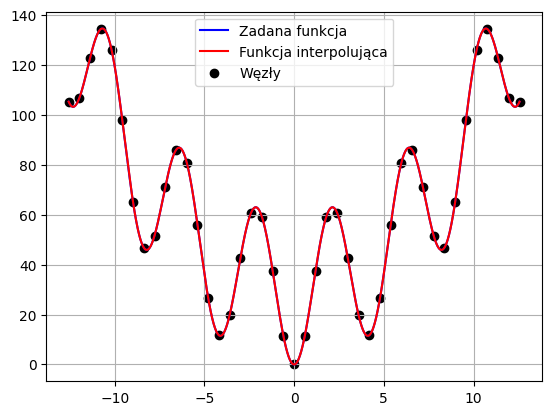

In [18]:
draw_interpolation(lagrange_interpolation, get_evenly_distributed, 43, "img04")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji lagrangea i liczby węzłów czebyszewa z przedziału [3, 100]

In [45]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(lagrange_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

1.9895196601282805e-13 50 73.3439742849674 14


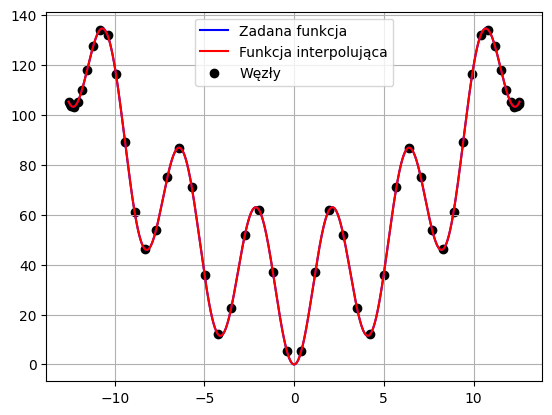

In [48]:
draw_interpolation(lagrange_interpolation, get_chebyshev_nodes, 50, "img05")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji lagrangea i liczby węzłów czebyszewa z przedziału [3, 100]

In [19]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(lagrange_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

2.296897441475515e-27 54 998.0056040384796 9


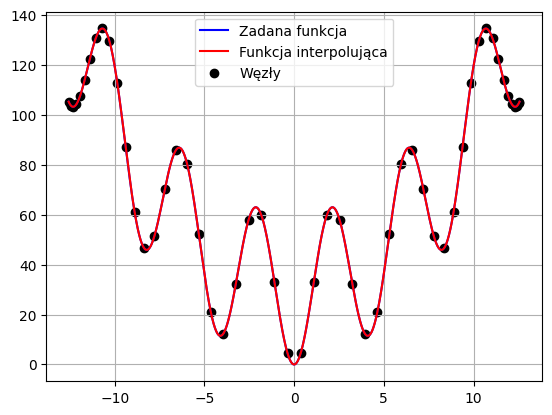

In [22]:
draw_interpolation(lagrange_interpolation, get_chebyshev_nodes, 54, "img06")

Efekt Rungego

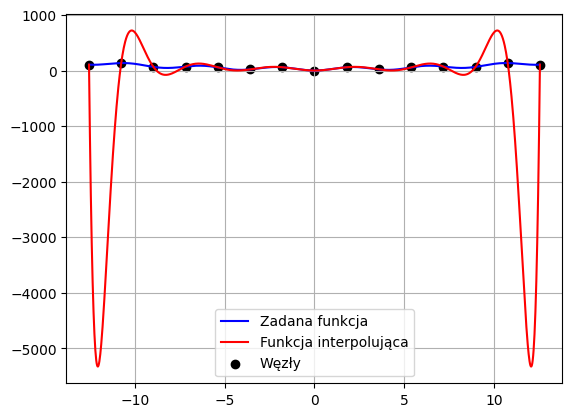

In [23]:
draw_interpolation(lagrange_interpolation, get_evenly_distributed, 15, "img07")

Przykładowy wykres dla interpolacji Newtona i równoodległych węzłów

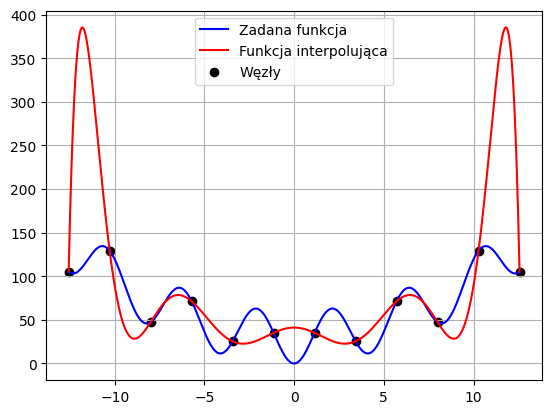

In [24]:
draw_interpolation(newton_interpolation, get_evenly_distributed, 12, "img08")

Przykładowy wykres dla interpolacji Newtona i węzłów Czebyszewa

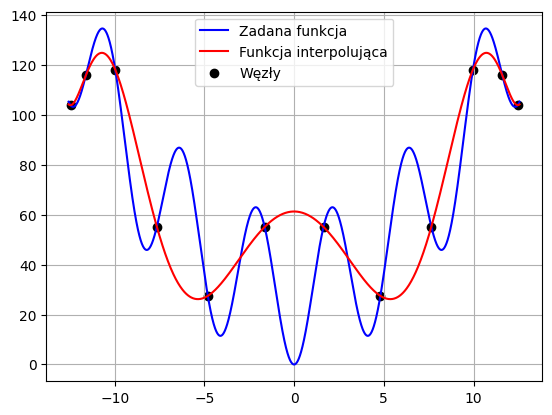

In [25]:
draw_interpolation(newton_interpolation, get_chebyshev_nodes, 12, "img09")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji newtona i liczby równoodległych węzłów z przedziału [3, 100]

In [27]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(newton_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.00010909281184012798 43 2270893506976798.0 100


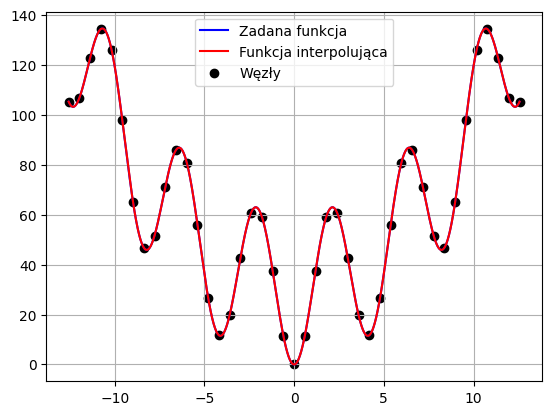

In [28]:
draw_interpolation(newton_interpolation, get_evenly_distributed, 43, "img10")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji newtona i liczby równoodległych węzłów z przedziału [3, 100]

In [29]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(newton_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

8.220356191804188e-11 44 1.378991064311306e+28 100


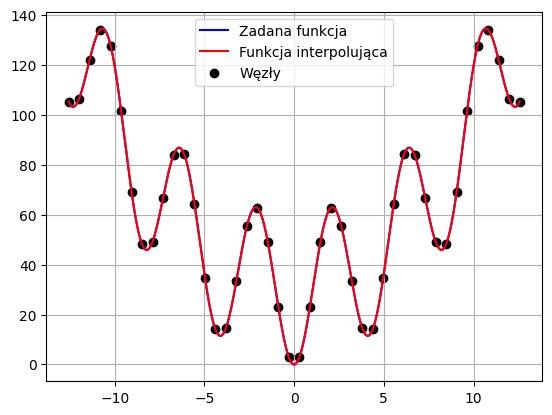

In [30]:
draw_interpolation(newton_interpolation, get_evenly_distributed, 44, "img11")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji newtona i liczby węzłów czebyszewa z przedziału [3, 100]

In [31]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(newton_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

6.877908359115281e-05 33 1.2329365358798774e+18 100


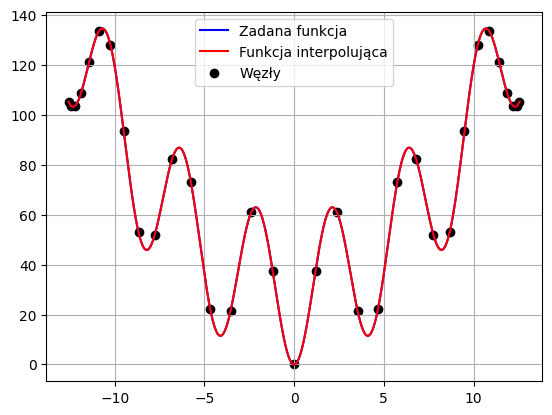

In [32]:
draw_interpolation(newton_interpolation, get_chebyshev_nodes, 33, "img12")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji newtona i liczby węzłów czebyszewa z przedziału [3, 100]

In [33]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(newton_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

5.6728812264079556e-11 36 3.131365458153735e+33 100


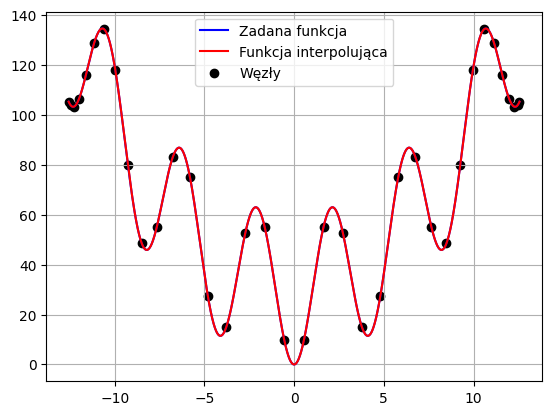

In [34]:
draw_interpolation(newton_interpolation, get_chebyshev_nodes, 36, "img13")

Efekt Rungego

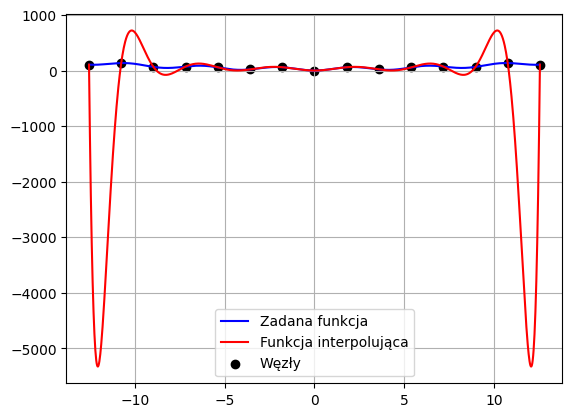

In [35]:
draw_interpolation(newton_interpolation, get_evenly_distributed, 15, "img14")

Przykładowy wykres dla interpolacji Hermite'a i równoodległych węzłów

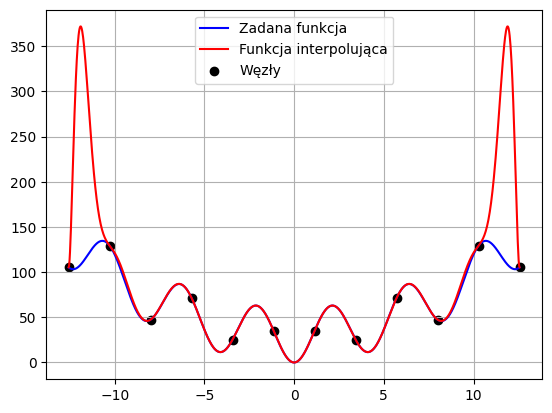

In [36]:
draw_interpolation(hermite_interpolation, get_evenly_distributed, 12, "img15")

Przykładowy wykres dla interpolacji Hermite'a i węzłów Czebyszewa

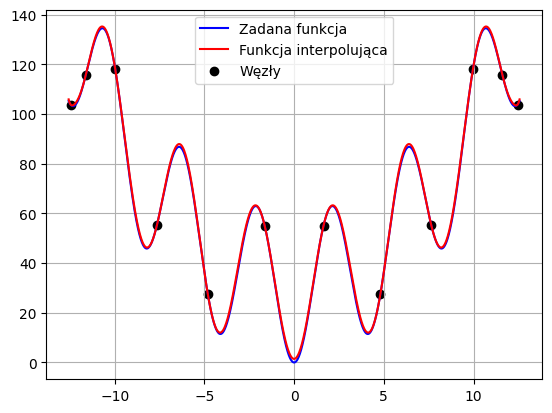

In [37]:
draw_interpolation(hermite_interpolation, get_chebyshev_nodes, 12, "img16")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji Hermite'a i liczby równoodległych węzłów z przedziału [3, 100]

In [38]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(hermite_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.0004611592085694838 21 1.0681376646237317e+63 100


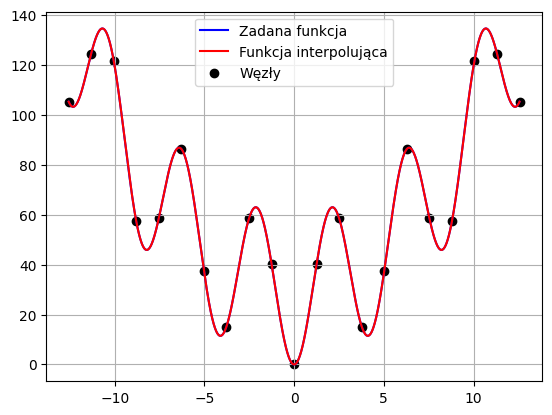

In [39]:
draw_interpolation(hermite_interpolation, get_evenly_distributed, 21, "img17")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji Hermite'a i liczby równoodległych węzłów z przedziału [3, 100]

In [40]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(hermite_interpolation, get_evenly_distributed, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

2.3730278769177324e-09 21 3.207451668536694e+123 100


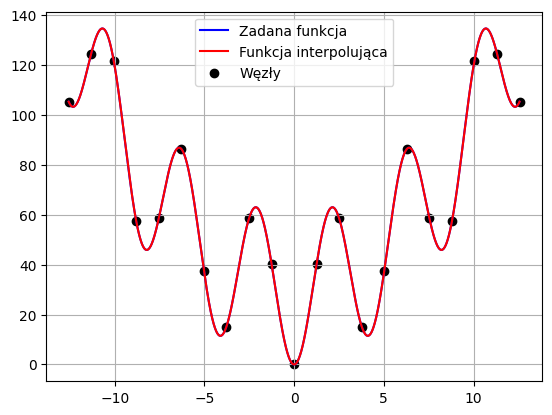

In [41]:
draw_interpolation(hermite_interpolation, get_evenly_distributed, 21, "img18")

Najlepsze przybliżenie ze względu na błąd maksymalny dla interpolacji hermite'a i liczby węzłów czebyszewa z przedziału [3, 100]

In [42]:
global_min, global_min_n, global_max, global_max_n = interpolation_maximum_difference(hermite_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.0002819640489661879 17 2.2725682274061917e+68 100


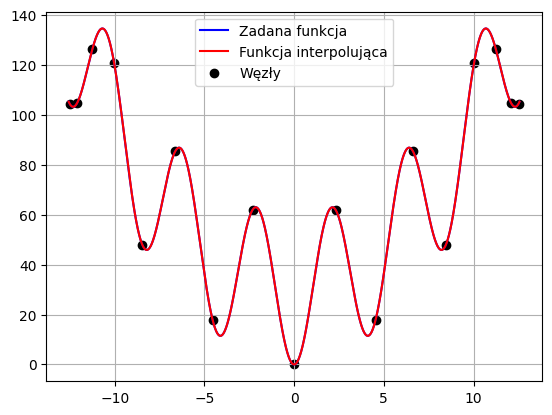

In [43]:
draw_interpolation(hermite_interpolation, get_chebyshev_nodes, 17, "img19")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla interpolacji newtona i liczby węzłów czebyszewa z przedziału [3, 100]

In [44]:
global_min, global_min_n, global_max, global_max_n = interpolation_mean_difference(hermite_interpolation, get_chebyshev_nodes, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

1.1739707228164544e-09 17 1.058838453668638e+134 100


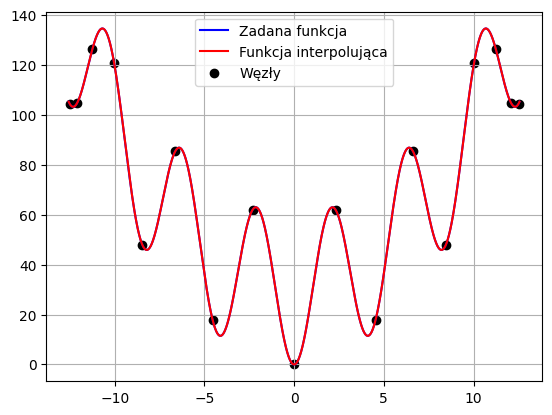

In [45]:
draw_interpolation(hermite_interpolation, get_chebyshev_nodes, 17, "img20")

Efekt Rungego

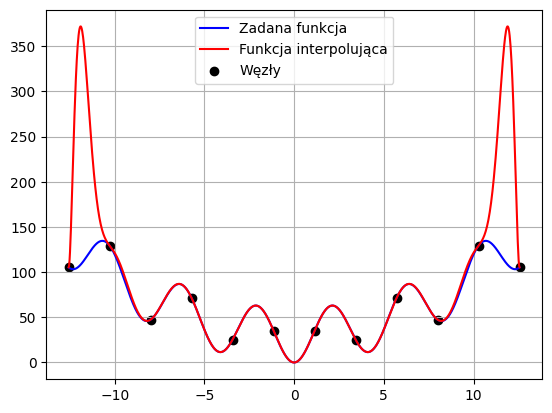

In [47]:
draw_interpolation(hermite_interpolation, get_evenly_distributed, 12, "img21")

FUNKCJE SKLEJANE

Sześcienna funkcja sklejana

In [48]:
#Tak jak powyżej
def h(i, xs) -> float:
        return xs[i + 1] - xs[i]

In [49]:
def delta_1(i, xs, ys) -> float:
    return (ys[i + 1] - ys[i]) / (xs[i + 1] - xs[i]) 

In [50]:
def delta_2(i, xs, ys) -> float:
    return (delta_1(i + 1, xs, ys) - delta_1(i, xs, ys)) / (xs[i + 2] - xs[i])

In [51]:
def delta_3(i, xs, ys) -> float:
    return (delta_2(i + 1, xs, ys) - delta_2(i, xs, ys)) / (xs[i + 3] - xs[i]) 

In [52]:
#Funkcja przygotowuje dwie macierze narazie bez warunków brzegowych
def get_initial_matrix(xs, ys):
    
    n = len(xs)
    
    #Rzędów jest tyle ile sigm, czyli len(xs)
    A = np.zeros(shape=(n, n))
    C = np.zeros(shape=(n, 1))
    
    #Uzupełniam macieraze zgodnie ze wzorem powyżej, oprócz i = 0 oraz i = n, ponieważ tam idą warunku brzegowe
    #Należy zwrócić uwagę, że delty i h są przesunięte o 1 do tyłu ze względu na numerację tablic od 0
    for i in range(1, n - 1):
        A[i][i - 1] = h(i - 1, xs) 
        A[i][i] = 2 * (h(i - 1, xs) + h(i, xs))
        A[i][i + 1] = h(i, xs)
        
        C[i] = delta_1(i, xs, ys) - delta_1(i - 1, xs, ys)
        
    return A, C

Cubic spline boundary

In [53]:
def cubic_boundary(A, C, xs, ys):
    
    A[0][0] = -h(0, xs)
    A[0][1] = h(0, xs)
    
    A[-1][-2] = h(len(A) - 2, xs)
    A[-1][-1] = -h(len(A) - 2, xs)
    
    C[0] = (h(0, xs) ** 2) * delta_3(0, xs, ys)
    C[-1] = -(h(len(C) - 2, xs) ** 2) * delta_3(len(C) - 4, xs, ys)
    
    sigma = np.linalg.solve(A, C)
    
    return list(chain.from_iterable(sigma)) #np.linalg.solve zwraca lista = [[val1], [val2], [val3], ...], a ja chce list = [val1, val2, val3, ....]

Natural cubic spline boundary

In [54]:
def natural_cubic_boundary(A, C):
    
    #Ponieważ sigma_i = 1/6 * S_i''(x_i), skoro S_i'' = 0 to sigma tez = 0
    #Dzięki temu warunkowi wystarczy, że rozwiązać n - 2 równań, bo sigma(1) = sigma(n) = 0
    
    
    #ten kod choć poprawny generuje niemal niemożliwe do wykrycia problemy (~2 godziny debugowania na ślepo, dodatkowo problem nie występował
    #dla równoodległych węzłów, tylko dla węzłów Czbyszewa!)
    #A = A[1:-1, 1:-1]
    #C = C[1:-1]
    # [0, *np.linalg.solve(A, C), 0] 
    
    A[0][0] = 1
    A[0][1] = 0
    
    A[-1][-1] = 1
    A[-1][-2] = 0
    
    C[0] = 0
    C[-1] = 0
    
    
    sigma = np.linalg.solve(A, C)
    
    return list(chain.from_iterable(sigma)) #np.linalg.solve zwraca lista = [[val1], [val2], [val3], ...], a ja chce list = [val1, val2, val3, ....]

In [55]:
def search_range_idx(xs, x):
    
    l = 0
    r = len(xs) - 1

    while l <= r:
        m = (l + r) // 2
        if x >= xs[m]:
            l = m + 1
        else:
            r = m - 1

    return l - 1

In [56]:
# boundary_type:
# 0 - cubic_boundary
# 1 - natural_cubic_boundary

def cubic_spline(x, xs, ys, boundary_type) -> float:
        
        # tak jak w przypadku linear_spline trzeba poznać pozycję x-a w liście xs
        #i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
        i = max(0, min(search_range_idx(xs, x), len(xs) - 2))
    
        #Tworzę obie macierze
        A, C = get_initial_matrix(xs, ys)
        sigma = []
        
        if(boundary_type == 0): sigma = cubic_boundary(A, C, xs, ys)
        elif(boundary_type == 1): sigma = natural_cubic_boundary(A, C)
        
        # zgodnie z powyższym wzorem

        b = ( (ys[i + 1] - ys[i]) / h(i, xs) ) - h(i, xs) * (sigma[i + 1] + 2 * sigma[i])
        c = 3 * sigma[i]
        d = (sigma[i + 1] - sigma[i]) / h(i, xs)

        
        return ys[i] + b * (x - xs[i]) + c * ((x - xs[i]) ** 2 ) + d * ((x - xs[i]) ** 3)

4. Kwadratowa funkcja sklejana

Natural spline boundary

In [57]:
class Natural_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return 0
        
        return 2 * Natural_quadratic_boundary.get_v(i, xs, ys) - Natural_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        return ((Natural_quadratic_boundary.get_b(i + 1, xs, ys) - Natural_quadratic_boundary.get_b(i, xs, ys)) /
           (2 * (xs[i + 1] - xs[i])))

Clamped spline boundary

In [58]:
class Clamped_quadratic_boundary():
    
    @staticmethod
    def get_v(i, xs, ys):
        return (ys[i] - ys[i - 1]) / (xs[i] - xs[i - 1])
        
    @staticmethod
    def get_b(i, xs, ys):
        
        if i == 0: # warunek brzegowy
            return Clamped_quadratic_boundary.get_v(1, xs, ys)
        
        return 2 * Clamped_quadratic_boundary.get_v(i, xs, ys) - Clamped_quadratic_boundary.get_b(i - 1, xs, ys)
    
    @staticmethod
    def get_c(i, xs, ys):
        return ((Clamped_quadratic_boundary.get_b(i + 1, xs, ys) - Clamped_quadratic_boundary.get_b(i, xs, ys)) / 
               (2 * (xs[i + 1] - xs[i])))

In [59]:
def search_range_idx(xs, x):
    
    l = 0
    r = len(xs) - 1

    while l <= r:
        m = (l + r) // 2
        if x >= xs[m]:
            l = m + 1
        else:
            r = m - 1

    return l - 1

In [60]:
def quadratic_spline(x, xs, ys, boundary):
    
    #i = min(bisect_right(xs, x) - 1, len(xs) - 2) 
    i = max(0, min(search_range_idx(xs, x), len(xs) - 2))
    b = boundary.get_b(i, xs, ys)
    c = boundary.get_c(i, xs, ys)
    
    return ys[i] + b * (x - xs[i]) +  c * ((x - xs[i]) ** 2)

In [63]:
class Interpolation(Enum):
    LINEAR = "Linear spline"
    CUBIC = "Cubic spline with cubic boundary"
    CUBIC_NATURAL = "Cubic spline with natural boundary"
    QUADRATIC_NATURAL = "Quadratic spline with natural boundary"
    QUADRATIC_CLAMPED = "Quadratic spline with clamped boundary"

In [70]:
def interpolate(spline_type, n, filename, test_points_count = 1000, nodes_plot_label = 'Węzły'):
    
    xs = get_evenly_distributed(f_range_a, f_range_b, n)
    ys = [ f(xs[i]) for i in range(len(xs))]
    
    check_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
    check_y = []

    for i in range(len(check_x)):

        if(spline_type == Interpolation.CUBIC): 
            check_y.append(cubic_spline(check_x[i], xs, ys, 0))
        elif(spline_type == Interpolation.CUBIC_NATURAL): 
            check_y.append(cubic_spline(check_x[i], xs, ys, 1))
        elif(spline_type == Interpolation.QUADRATIC_NATURAL): 
            check_y.append(quadratic_spline(check_x[i], xs, ys, Natural_quadratic_boundary))
        elif(spline_type == Interpolation.QUADRATIC_CLAMPED): 
            check_y.append(quadratic_spline(check_x[i], xs, ys, Clamped_quadratic_boundary))
    
    plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "blue")
    
    plt.plot(check_x, check_y, color = 'red', label = "Funkcja interpolująca")
    plt.scatter(xs, ys, color = 'black', label=nodes_plot_label)
    
    plt.title(spline_type.value)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename + ".png")
    plt.show()

In [75]:
def spline_maximum_difference(spline_type, test_points_count, interpolation_range_a, intepolation_range_b):

    #Wartości n do przetestowania od 3 do 30
    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    global_max = float('-inf')
    global_min = float('inf')
    
    global_max_n = -1
    global_max_n = -1

    for i in range(len(N)):

        maksimum = float('-inf')

        #Evenly distributed xs
        xs = get_evenly_distributed(f_range_a, f_range_b, N[i])
        ys = [f(xs[j]) for j in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            if(spline_type == Interpolation.CUBIC):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 0)))
            elif(spline_type == Interpolation.CUBIC_NATURAL):
                temp = abs(f(test_x[j]) - (cubic_spline(test_x[j], xs, ys, 1)))
            elif(spline_type == Interpolation.QUADRATIC_NATURAL):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Natural_quadratic_boundary)))
            elif(spline_type == Interpolation.QUADRATIC_CLAMPED):
                temp = abs(f(test_x[j]) - (quadratic_spline(test_x[j], xs, ys, Clamped_quadratic_boundary)))
            
            maksimum = temp if temp > maksimum else maksimum
    
        if maksimum > global_max: 
            global_max = maksimum
            global_max_n = N[i]
        if maksimum < global_min: 
            global_min = maksimum
            global_min_n = N[i]
            
    return global_min, global_min_n, global_max, global_max_n

In [84]:
def spline_mean_difference(spline_type, test_points_count, interpolation_range_a, intepolation_range_b):

    N = [i for i in range(interpolation_range_a, intepolation_range_b + 1)]

    global_max = float('-inf')
    global_min = float('inf')
    
    global_max_n = -1
    global_max_n = -1

    for i in range(len(N)):

        suma = 0

        #Evenly distributed xs
        xs = get_evenly_distributed(f_range_a, f_range_b, N[i])
        ys = [ f(xs[j]) for j in range(len(xs))]

        test_x = get_evenly_distributed(f_range_a, f_range_b, test_points_count)
        
        for j in range(test_points_count):

            if(spline_type == Interpolation.LINEAR): 
                suma += (f(test_x[j]) - linear_spline(test_x[j], xs, ys)) ** 2
            elif(spline_type == Interpolation.CUBIC):
                suma += (f(test_x[j]) - cubic_spline(test_x[j], xs, ys, 0)) ** 2
            elif(spline_type == Interpolation.CUBIC_NATURAL):
                suma += (f(test_x[j]) - cubic_spline(test_x[j], xs, ys, 1)) ** 2
            elif(spline_type == Interpolation.QUADRATIC_NATURAL):
                suma += (f(test_x[j]) - quadratic_spline(test_x[j], xs, ys, Natural_quadratic_boundary)) ** 2
            elif(spline_type == Interpolation.QUADRATIC_CLAMPED):
                suma += (f(test_x[j]) - quadratic_spline(test_x[j], xs, ys, Clamped_quadratic_boundary)) ** 2

        suma /= test_points_count
        
        if suma > global_max:
            global_max = suma
            global_max_n = N[i]
            
        if suma < global_min:
            global_min = suma
            global_min_n = N[i]

    return global_min, global_min_n, global_max, global_max_n

Przykładowy wykres interpolacji funkcją sklejną 2-go stopnia i natural boundary

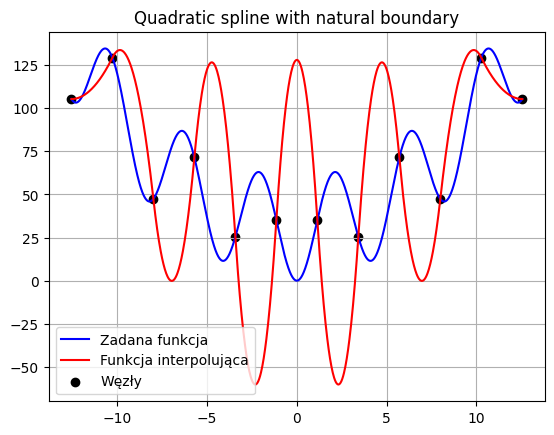

In [71]:
interpolate(Interpolation.QUADRATIC_NATURAL, 12, "img22")

Przykładowy wykres interpolacji funkcją sklejną 2-go stopnia i clamped boundary

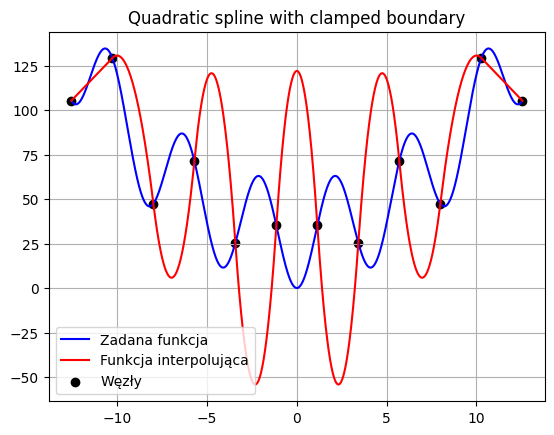

In [72]:
interpolate(Interpolation.QUADRATIC_CLAMPED, 12, "img23")

Najlepsze przybliżenie ze względu na błąd maksymalny dla funkcji sklejanej 2-go stopnia i natural boundary oraz liczby węzłów z przedziału [3, 100]

In [76]:
global_min, global_min_n, global_max, global_max_n = spline_maximum_difference(Interpolation.QUADRATIC_NATURAL, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

1.0681449955008588 100 336.408265565484 13


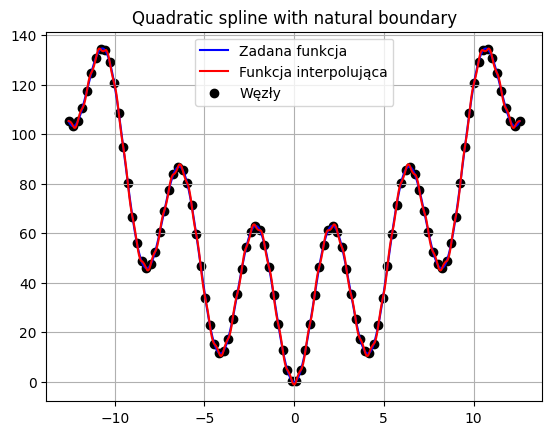

In [88]:
interpolate(Interpolation.QUADRATIC_NATURAL, 100, "img24")

Najlepsze przybliżenie ze względu na błąd sredniokwadratowy dla funkcji sklejanej 2-go stopnia i natural boundary oraz liczby węzłów z przedziału [3, 100]

In [85]:
global_min, global_min_n, global_max, global_max_n = spline_mean_difference(Interpolation.QUADRATIC_NATURAL, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.6024828002833287 100 21355.74596592308 13


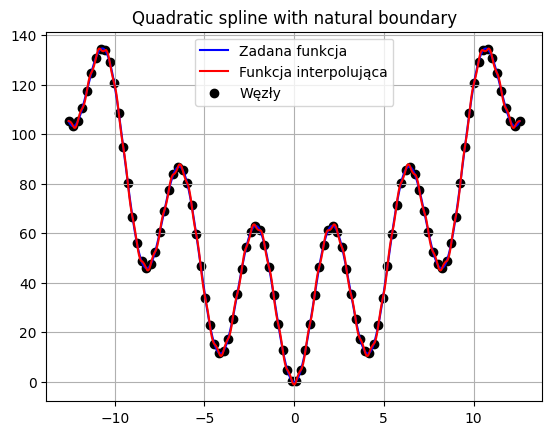

In [89]:
interpolate(Interpolation.QUADRATIC_NATURAL, 100, "img25")

Najlepsze przybliżenie ze względu na błąd maksymalny dla funkcji sklejanej 2-go stopnia i clamped boundary oraz liczby węzłów z przedziału [3, 100]

In [87]:
global_min, global_min_n, global_max, global_max_n = spline_maximum_difference(Interpolation.QUADRATIC_CLAMPED, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.5527769402251668 100 329.4517341562276 13


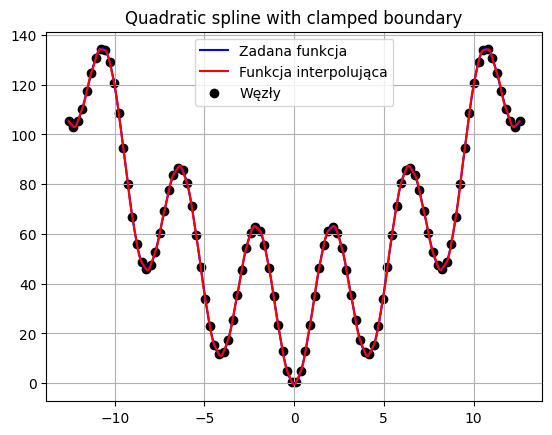

In [95]:
interpolate(Interpolation.QUADRATIC_CLAMPED, 100, "img26")

Najlepsze przybliżenie ze względu na błąd sredniokwadratowy dla funkcji sklejanej 2-go stopnia i clamped boundary oraz liczby węzłów z przedziału [3, 100]

In [91]:
global_min, global_min_n, global_max, global_max_n = spline_mean_difference(Interpolation.QUADRATIC_CLAMPED, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.16001239042418153 100 20111.970018862332 13


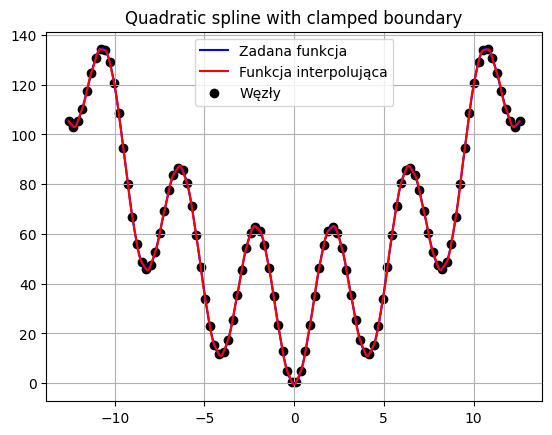

In [96]:
interpolate(Interpolation.QUADRATIC_CLAMPED, 100, "img27")

Przykładowy wykres interpolacji funkcją sklejaną 3-go stopnia i default boundary

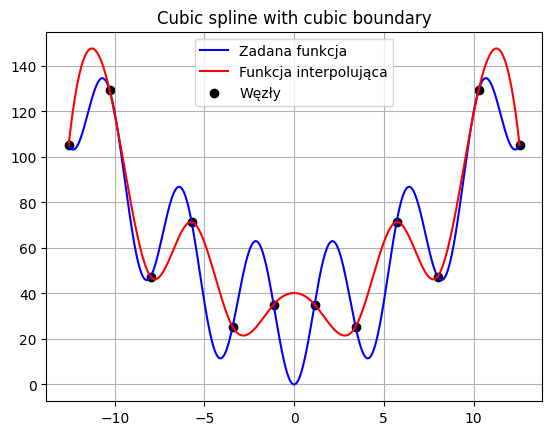

In [98]:
interpolate(Interpolation.CUBIC, 12, "img28")

Przykładowy wykres interpolacji funkcją sklejaną 3-go stopnia i clamped boundary

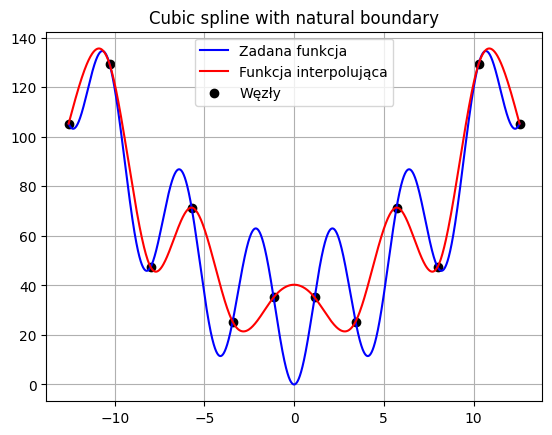

In [99]:
interpolate(Interpolation.CUBIC_NATURAL, 12, "img29")

Najlepsze przybliżenie ze względu na błąd maksymalny dla funkcji sklejanej 3-go stopnia i default boundary oraz liczby węzłów z przedziału [4, 100] (4, ze względu na specyfikę warunku (opisane w sprawozdaniu ze spline'ów))

In [102]:
global_min, global_min_n, global_max, global_max_n = spline_maximum_difference(Interpolation.CUBIC, 1000, 4, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.020287863798969852 100 68.1601496979736 5


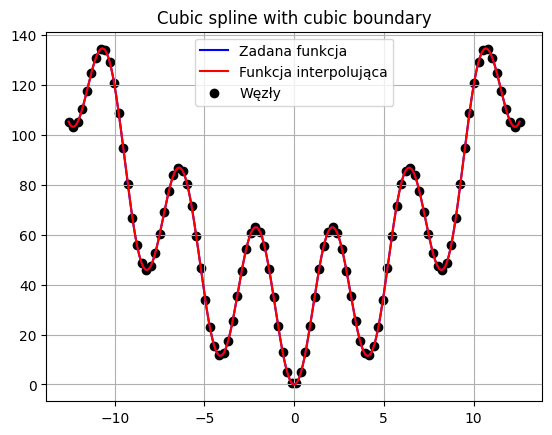

In [103]:
interpolate(Interpolation.CUBIC, 100, "img30")

Najlepsze przybliżenie ze względu na błąd sredniokwadratowy dla funkcji sklejanej 3-go stopnia i default boundary oraz liczby węzłów z przedziału [4, 100]

In [105]:
global_min, global_min_n, global_max, global_max_n = spline_mean_difference(Interpolation.CUBIC, 1000, 4, 100)
print(global_min, global_min_n, global_max, global_max_n)

5.120217597086769e-06 100 1348.6499999999992 7


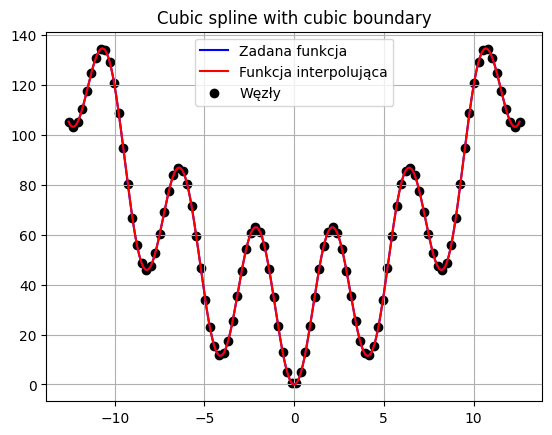

In [107]:
interpolate(Interpolation.CUBIC, 100, "img31")

Najlepsze przybliżenie ze względu na błąd maksymalny dla funkcji sklejanej 3-go stopnia i natural boundary oraz liczby węzłów z przedziału [3, 100]

In [108]:
global_min, global_min_n, global_max, global_max_n = spline_maximum_difference(Interpolation.CUBIC_NATURAL, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.2216068253697614 100 61.75307219867342 4


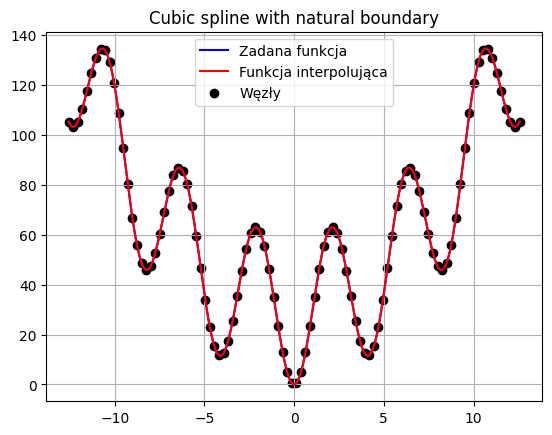

In [109]:
interpolate(Interpolation.CUBIC_NATURAL, 100, "img32")

Najlepsze przybliżenie ze względu na błąd średniokwadratowy dla funkcji sklejanej 3-go stopnia i natural boundary oraz liczby węzłów z przedziału [3, 100]

In [110]:
global_min, global_min_n, global_max, global_max_n = spline_mean_difference(Interpolation.CUBIC_NATURAL, 1000, 3, 100)
print(global_min, global_min_n, global_max, global_max_n)

0.0005181051145680916 100 1334.226331551487 7


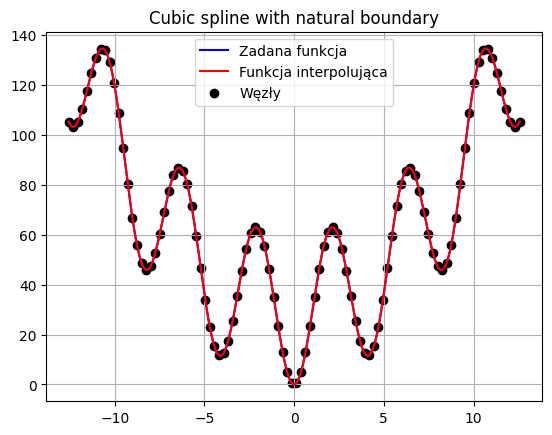

In [111]:
interpolate(Interpolation.CUBIC_NATURAL, 100, "img33")

APROKSYMACJA

Aproksymacja średniokwadratowa wielomianami algebraicznymi

In [112]:
def calculate_approx_algebraic(xs, ys, m, w):
    
    G = np.zeros((m + 1, m + 1))
    B = np.zeros(m + 1)

    for j in range(m + 1):
        for k in range(m + 1):
            G[j][k] = sum([w[i] * (xs[i] ** min(j + k, 2 * m + 1)) for i in range(len(xs))])
        
        B[j] = sum([w[i] * ys[i] * (xs[i] ** j) for i in range(len(xs))])
   
    A = np.linalg.solve(G, B)
    
    return lambda x : sum([A[i] * (x ** i) for i in range(m + 1)])

In [113]:
def draw_approx_algebraic(n, m, img):

    xs = np.linspace(f_range_a, f_range_b, n)
    ys = [f(xs[i]) for i in range(len(xs))]
    
    w = [1 for _ in range(len(xs))]

    calculated_function = calculate_approx_algebraic(xs, ys, m, w)

    plot_function(f, f_range_a, f_range_b, "Zadana funkcja", "blue")
    
    plot_function(calculated_function, f_range_a, f_range_b, "Funkcja aproksymująca", "red")
    
    #plt.plot(xs, calculated_ys, color = 'red', label = "Funkcja Funkcja interpolowana")
    plt.scatter(xs, ys, color = 'black', label = "Nodes")
    plt.title("Function approximation")
    plt.legend()
    plt.grid(True)
    plt.savefig(img + ".png")
    plt.show()

In [115]:
def approx_algebraic(n, m, w):
    xs = np.linspace(f_range_a, f_range_b, n)
    ys = [f(xs[i]) for i in range(len(xs))]
    
    calculated_function = calculate_approx_algebraic(xs, ys, m, w)

    return calculated_function

In [116]:
def approximation_maximum_difference(n, m, test_points = 1000):

    maksimum = float('-inf')

    #Evenly distributed xs
    xs = np.linspace(f_range_a, f_range_b, test_points)
        
    approx_function = approx_approx_algebraic(n, m, [1 for _ in range(n)])

    for i in range(test_points):

        temp = abs(f(xs[i]) - approx_function(xs[i]))

        maksimum = temp if temp > maksimum else maksimum
    
    return maksimum

In [117]:
def approximation_mean_difference(n, m, test_points = 1000):

    suma = 0

    xs = np.linspace(f_range_a, f_range_b, test_points)
        
    approx_function = approx_approx_algebraic(n, m, [1 for _ in range(n)])

    for i in range(test_points):

        suma += (f(xs[i]) - approx_function(xs[i]))
    
    return(f"{suma / test_points}")

In [ ]:
def errors_m(n):
    
    max_diff = [approximation_maximum_difference(n, m, 1000) for m in range(3, n + 1)]
    mean_diff = [approximation_mean_difference(n, m, 1000) for m in range(3, n + 1)]
    
    return

Przykłądowy wykres aproksymacji wielomianami algebraicznymi

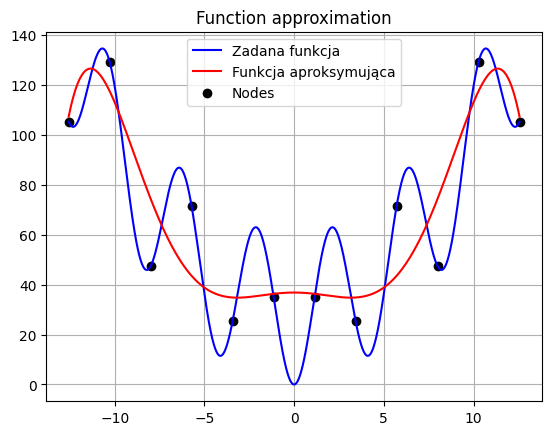

In [114]:
draw_approx_algebraic(12, 6, "img34")